In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [2]:
np.random.seed(42)

In [3]:
n_A,p_A = 10_000,0.10
n_B,p_B = 10_000,0.12

In [4]:
success_A = np.random.binomial(n_A,p_A)
success_B = np.random.binomial(n_B,p_B)

In [5]:
# 2.calculate conversion Rates & 95% CIs

def proportion_ci(successes,n,alpha=0.05):
  p_hat = successes/n
  z = stats.norm.ppf(1-alpha/2)
  se = np.sqrt(p_hat*(1-p_hat)/n)
  return p_hat,p_hat - z*se,p_hat + z*se

p_A_hat,ci_low_A,ci_high_A=proportion_ci(success_A,n_A)
p_B_hat,ci_low_B,ci_high_B=proportion_ci(success_B,n_B)

results = pd.DataFrame({
    'variant': ['A','B'],
    'Visitors': [n_A,n_B],
    'Conversions': [p_A_hat,p_B_hat],
    'CI lower (95%)': [ci_low_A,ci_low_B],
    'CI upper (95%)': [ci_high_A,ci_high_B]
})
print(results)

  variant  Visitors  Conversions  CI lower (95%)  CI upper (95%)
0       A     10000       0.0973        0.091491        0.103109
1       B     10000       0.1134        0.107185        0.119615


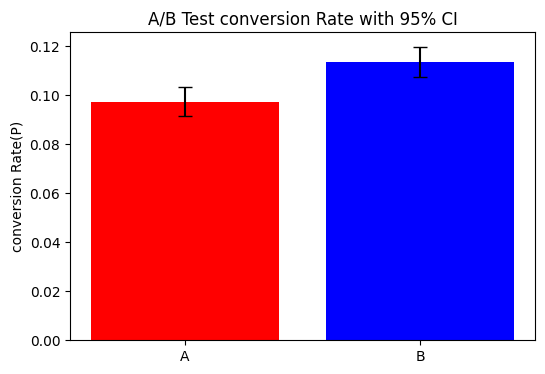

In [6]:
# 3.plot conversion Rates with error bars
plt.figure(figsize=(6,4))
plt.bar(
    results['variant'],
    results['Conversions'],
    yerr=[
        results['Conversions'] - results['CI lower (95%)'],
        results['CI upper (95%)'] - results['Conversions']
    ],
    capsize=5,
    color=['red','blue']
)
plt.ylabel('conversion Rate(P)')
plt.title('A/B Test conversion Rate with 95% CI')
plt.show()

In [7]:
from statsmodels.stats.proportion import proportions_ztest

# 4. Two-Proportion z-Test

# Test H0: p_B ≤ p_A  vs  H1: p_B > p_A
count = np.array([success_B, success_A])
nobs = np.array([n_B, n_A])

z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')

print(f"z-statistic: {z_stat:.3f}")
print(f"p-value: {p_value:.3f}")

if p_value < 0.05:
    print("⇒ Reject H₀: Variant B has a significantly higher conversion rate.")
else:
    print("⇒ Fail to reject H₀: No significant difference in conversion rates.")

z-statistic: 3.708
p-value: 0.000
⇒ Reject H₀: Variant B has a significantly higher conversion rate.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import time
from statsmodels.stats.proportion import proportions_ztest
from IPython.display import clear_output

# Use the same true rates from above
true_p_A, true_p_B = 0.10, 0.12

batch_size = 100       # visitors per batch per variant
n_batches = 60         # simulate 60 time steps (e.g. minutes)

# Initialize counters
n_visits_A = n_visits_B = 0
n_succ_A = n_succ_B = 0


In [9]:
# lists to store metrics for plotting
batches=[]
p_values=[]
lifts=[]

Batch 60/60
Variant A: 6000 visitors, 574 successes, CR: 9.567%
Variant B: 6000 visitors, 714 successes, CR: 11.900%
Observed Lift: 2.333%
z-stat: 4.13,p_value=0.0000
-> Significant lift detected(p,0.05).


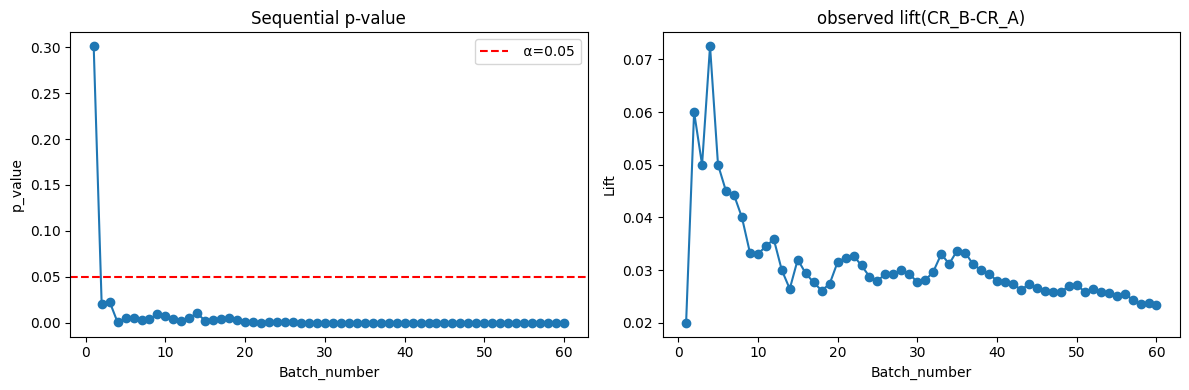

In [10]:
for batch in range(1, n_batches+1):
    # Simulate one batch of visitors
    new_A = np.random.binomial(batch_size, true_p_A)
    new_B = np.random.binomial(batch_size, true_p_B)

    # Update totals
    n_visits_A += batch_size
    n_visits_B += batch_size
    n_succ_A += new_A
    n_succ_B += new_B

    # Compute current conversion rates
    cr_A = n_succ_A / n_visits_A
    cr_B = n_succ_B / n_visits_B
    lift= cr_B - cr_A

    # two proportion z test (one-side: B > A)
    count = np.array([n_succ_B, n_succ_A])
    nobs = np.array([n_visits_B, n_visits_A])
    z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')

    # RECORD for plotting
    batches.append(batch)
    p_values.append(p_value)
    lifts.append(lift)

    #Clear previous output and print current stats
    clear_output(wait=True)
    print(f"Batch {batch}/{n_batches}")
    print(f"Variant A: {n_visits_A} visitors, {n_succ_A} successes, CR: {cr_A:.3%}")
    print(f"Variant B: {n_visits_B} visitors, {n_succ_B} successes, CR: {cr_B:.3%}")
    print(f"Observed Lift: {lift:.3%}")
    print(f"z-stat: {z_stat:.2f},p_value={p_value:.4f}")
    if p_value < 0.05:
        print("-> Significant lift detected(p,0.05).")
    else:
        print("-> No Significant lift yet.")

#plot p_value and lift over batches
fig, axes = plt.subplots(1,2,figsize=(12, 4))
axes[0].plot(batches,p_values,'-o')
axes[0].axhline(0.05,color='red',linestyle='--',label=' α=0.05')
axes[0].set_title('Sequential p-value')
axes[0].set_xlabel('Batch_number')
axes[0].set_ylabel('p_value')
axes[0].legend()

axes[1].plot(batches,lifts,'-o')
axes[1].set_title('observed lift(CR_B-CR_A)')
axes[1].set_xlabel('Batch_number')
axes[1].set_ylabel('Lift')


plt.tight_layout()
plt.show()